In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import missingno as msno
import warnings
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [9]:
data = pd.read_csv('data/ads_train.csv') 
data.dtypes.value_counts()
new_col = ['isbuyer', 'visit_freq', 'buy_interval', 'sv_interval',
       'expected_time_buy', 'expected_time_visit', 'last_buy', 'last_visit',
       'multiple_buy', 'multiple_visit', 'uniq_urls', 'num_checkins', 'y_buy']
data = data[new_col]
col = data.select_dtypes(include=['int64','float64']).columns
col = col.drop('y_buy')
data_ml_df = data
sc = StandardScaler()
data_ml_df[col] = sc.fit_transform(data_ml_df[col])
data_ml_df.head()
x_feature = list(data_ml_df.columns)
x_feature.remove('y_buy')
x_val = data_ml_df[x_feature]
y_val = data_ml_df['y_buy']
X = data_ml_df[col]
y = data_ml_df['y_buy']
sm = SMOTE(random_state=42)
X_source, y_source = X, y
X, y = sm.fit_sample(X, y)
print('通过SMOTE方法平衡正负样本后')
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def different_thrsholds(X, y, thresholds, model):
    y_pred_proba = model.predict_proba(X)  #predict_prob 获得一个概率值

    plt.figure(figsize=(30,10))

    j = 1
    for i in thresholds:
        y_test_predictions_high_recall = y_pred_proba[:,1] > i#预测出来的概率值是否大于阈值 

        plt.subplot(6,3,j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y, y_test_predictions_high_recall)
        np.set_printoptions(precision=2)

        print("Recall metric in the testing dataset: ",(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

        # Plot non-normalized confusion matrix
        class_names = [0,1]
        plot_confusion_matrix(cnf_matrix
                              , classes=class_names)

通过SMOTE方法平衡正负样本后
样本个数：76074; 正样本占50.00%; 负样本占50.00%


#### SGD模型

Test set accuracy score: 0.86239
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     32885
           1       0.69      0.02      0.04      5324

   micro avg       0.86      0.86      0.86     38209
   macro avg       0.78      0.51      0.48     38209
weighted avg       0.84      0.86      0.80     38209

Recall metric in the testing dataset:  0.9767441860465116
Recall metric in the testing dataset:  0.9534883720930233
Recall metric in the testing dataset:  0.9418604651162791
Recall metric in the testing dataset:  0.9244186046511628
Recall metric in the testing dataset:  0.872093023255814
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.7267441860465116
Recall metric in the testing dataset:  0.7034883720930233
Recall metric in the testing dataset:  0.6918604651162791
Recall metric in the testing dataset:  0.6686046511627907
Recall metric in the testing dataset:  0.6569767441860465
Rec

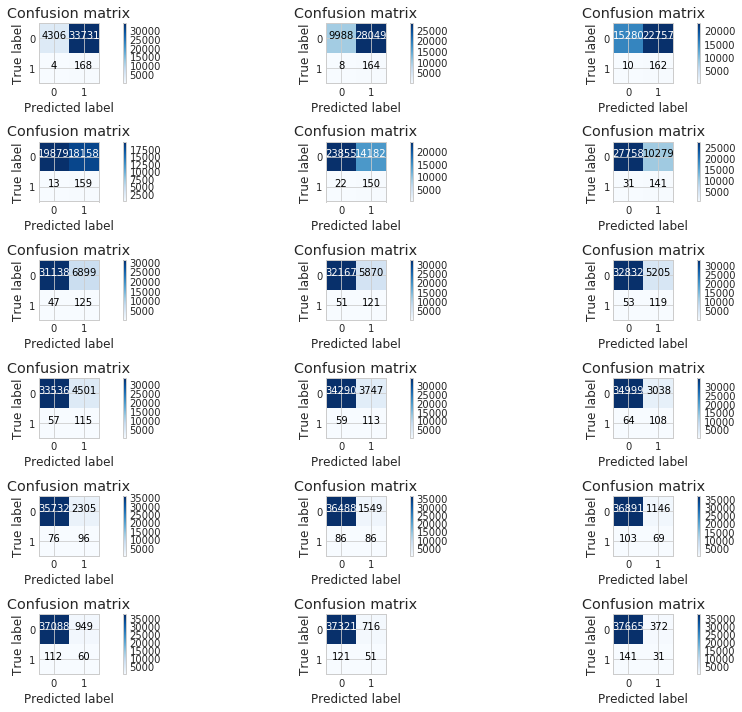

In [8]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'penalty': ['l2', 'l1', 'elasticnet'],
             'max_iter':[5, 10, 20],
             'n_jobs':[-1]}
sgd_grid_search = GridSearchCV(SGDClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = sgd_grid_search.fit(X, y)
y_pred = sgd_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=sgd_grid_search)

#### RandomForest模型

In [ ]:
param_grid = {'n_estimators':[10, 100, 1000],
             'criterion':['gini', 'entropy'],
             'n_jobs':[-1],
             "warm_start":[False, True],
             "class_weight":[{0:1/38037, 1:1/172}, 'balanced', 'balanced_subsample']}
random_grid_search = GridSearchCV(RandomForestClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = random_grid_search.fit(X, y)
y_pred = random_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))

In [ ]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=sgd_grid_search)